# Shopper Gaze Monitor

This shopper gaze monitor application uses the Inference Engine included in the Intel® Distribution of OpenVINO™ toolkit and the Intel® Deep Learning Deployment Toolkit. It is designed for a retail shelf mounted camera system that counts the number of passers-by that look towards the display vs. the number of people that pass by the display without looking.

It is intended to provide real-world marketing statistics for in-store shelf-space advertising.
## Overview of how it works
At start-up the sample application reads the equivalent of command line arguments and loads a network and image from the video input to the Inference Engine (IE) plugin. A job is submitted to an edge compute node with a hardware accelerator such as Intel® HD Graphics GPU, Intel® Movidius™ Neural Compute Stick 2 and Intel® Arria® 10 FPGA.
After the inference is completed, the output videos are appropriately stored in the /results/[device] directory, which can then be viewed within the Jupyter Notebook instance.

## Demonstration objectives
* Video as input is supported using **OpenCV**
* Inference performed on edge hardware (rather than on the development node hosting this Jupyter notebook)
* **OpenCV** provides the bounding boxes, labels and other information
* Visualization of the resulting bounding boxes


## Step 0: Set Up

### 0.1: Import dependencies

Run the below cell to import Python dependencies needed for displaying the results in this notebook
(tip: select the cell and use **Ctrl+enter** to run the cell)

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *

### 0.2  (Optional-step): Original video without inference

If you are curious to see the input video, run the following cell to view the original video stream used for inference and shopper gaze monitor.

In [2]:
!ln -sf ./resources/face-demographics-walking-and-pause.mp4 
videoHTML('Shopper video', ['face-demographics-walking-and-pause.mp4'])

## Step 1: Using Intel® Distribution of OpenVINO™ toolkit

We will be using Intel® Distribution of OpenVINO™ toolkit Inference Engine (IE) to locate face and head pose of the person in the frame.
There are five steps involved in this task:

1. Create an Intermediate Representation (IR) Model using the Model Optimizer by Intel
2. Choose a device and create IEPlugin for the device
3. Read the IRModel using IENetwork
4. Load the IENetwork into the Plugin
5. Run inference.

### 1.1 Creating IR Model

The Model Optimizer creates Intermediate Representation (IR) models that are optimized for different end-point target devices.
These models can be created from existing DNN models from popular frameworks (e.g. Caffe*, TF) using the Model Optimizer. 
The Intel® Distribution of OpenVINO™ toolkit includes a utility script `model_downloader.py` that you can use to download some common models. Run the following cell to see the models available through `model_downloader.py`

In [3]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --print_all

action-recognition-0001-decoder
action-recognition-0001-encoder
age-gender-recognition-retail-0013
driver-action-recognition-adas-0002-decoder
driver-action-recognition-adas-0002-encoder
emotions-recognition-retail-0003
face-detection-adas-0001
face-detection-adas-binary-0001
face-detection-retail-0004
face-detection-retail-0005
face-reidentification-retail-0095
facial-landmarks-35-adas-0002
gaze-estimation-adas-0002
handwritten-score-recognition-0003
head-pose-estimation-adas-0001
human-pose-estimation-0001
image-retrieval-0001
inceptionv3-int8-sparse-v1-tf-0001
inceptionv3-int8-sparse-v2-tf-0001
inceptionv3-int8-tf-0001
instance-segmentation-security-0010
instance-segmentation-security-0050
instance-segmentation-security-0083
landmarks-regression-retail-0009
license-plate-recognition-barrier-0001
mobilenetv2-int8-sparse-v1-tf-0001
mobilenetv2-int8-sparse-v2-tf-0001
mobilenetv2-int8-tf-0001
pedestrian-and-vehicle-detector-adas-0001
pedestrian-detection-adas-0002
pedestrian-detection-a

**Note**: The '!' is a special Jupyter Notebook command that allows you to run shell commands as if you are in a command line. So the above command will work straight out of the box on in a terminal (with '!' removed).

Some of these downloaded models are already in the IR format, while others will require the model optimizer. In this demo, we will be using the **face-detection-retail-0004** and **head-pose-estimation-adas-0001** model, which is already in IR format. This model can be downloaded with the following command.

In [4]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name face-detection-retail-0004 -o models
#!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name face-detection-retail-0004-fp16 -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name head-pose-estimation-adas-0001 -o models
#!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name head-pose-estimation-adas-0001-fp16 -o models

################|| Downloading models ||################

========== Downloading models/intel/face-detection-retail-0004/FP32/face-detection-retail-0004.xml
... 100%, 46 KB, 1328 KB/s, 0 seconds passed

========== Downloading models/intel/face-detection-retail-0004/FP32/face-detection-retail-0004.bin
... 100%, 2297 KB, 12856 KB/s, 0 seconds passed

========== Downloading models/intel/face-detection-retail-0004/FP16/face-detection-retail-0004.xml
... 100%, 46 KB, 1821 KB/s, 0 seconds passed

========== Downloading models/intel/face-detection-retail-0004/FP16/face-detection-retail-0004.bin
... 100%, 1148 KB, 10446 KB/s, 0 seconds passed

========== Downloading models/intel/face-detection-retail-0004/INT8/face-detection-retail-0004.xml
... 100%, 721 KB, 6445 KB/s, 0 seconds passed

========== Downloading models/intel/face-detection-retail-0004/INT8/face-detection-retail-0004.bin
... 100%, 2297 KB, 8055 KB/s, 0 seconds passed

################|| Post-processing ||################

########

The input arguments are as follows:
* --name : name of the model you want to download. It should be one of the models listed in the previous cell
* -o : output directory. If this directory does not exist, it will be created for you.

There are more arguments to this script and you can get the full list using the `-h` option.


With the `-o` option set as above, this command downloads the model in the directory `models`, with the model files (.xml and .bin) located at `/Retail/object_detection/face/sqnet1.0modif-ssd/0004/dldt/` and `/Transportation/object_attributes/headpose/vanilla_cnn/dldt/`


## Step 2 : Inference on a video

The inference code is already implemented in 
<a href="main.py">main.py</a>.

The Python code takes in command line arguments for video, model etc.

**Command line argument options and how they are interpreted in the application source code**

```
python3 shopper_gaze_monitor.py -m ${MODELPATH} \
                -i ${INPUT_FILE} \
                -o ${OUTPUT_FILE} \
                -d ${DEVICE} \
                -pm ${POSE_MODEL} \
                -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so

```

##### The description of the arguments used in the argument parser is the command line executable equivalent.
* -m location of the pre-trained IR model which has been pre-processed using the model optimizer. There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware for face detection
* -pm location of the pre-trained IR model which has been pre-processed using the model optimizer. There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware for head pose detection

* -i  location of the input video stream
* -o location where the output file with inference needs to be stored (results/[device])
* -d type of Hardware Acceleration (CPU, GPU, MYRIAD, HDDL or HETERO:FPGA,CPU)
* -l absolute path to the shared library and is currently optimized for core/xeon (/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so)

### 2.1 Creating job file
 
To run inference on the video, we need more compute power.
We will run the workload on several edge compute nodes represented in the IoT DevCloud. We will send work to the edge compute nodes by submitting the corresponding non-interactive jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

The job file is written in Bash, and will be executed directly on the edge compute node.
For this example, we have written the job file for you in the notebook.
Run the following cell to write this in to the file "shopper_monitor_job.sh"

In [5]:
%%writefile shopper_monitor_job.sh

#The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

#shopper_monitor_job script writes output to a file inside a directory. We make sure that this directory exists.
#The output directory is the first argument of the bash script
mkdir -p $1
OUTPUT_FILE=$1
DEVICE=$2
FP_MODEL=$3
INPUT_FILE=$4

if [ $DEVICE = "HETERO:FPGA,CPU" ]; then
    #Environment variables and compilation for edge compute nodes with FPGAs
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_bitstreams/2019R1_PL1_FP11_MobileNet_Clamp.aocx
fi

SAMPLEPATH=${PBS_O_WORKDIR}
if [ "$FP_MODEL" = "FP32" ]; then
  MODELPATH=${SAMPLEPATH}/models/intel/face-detection-retail-0004/FP32/face-detection-retail-0004.xml
else
  MODELPATH=${SAMPLEPATH}/models/intel/face-detection-retail-0004/FP16/face-detection-retail-0004.xml
fi

if [ "$FP_MODEL" = "FP32" ]; then
  POSE_MODEL=${SAMPLEPATH}/models/intel/head-pose-estimation-adas-0001/FP32/head-pose-estimation-adas-0001.xml
else
  POSE_MODEL=${SAMPLEPATH}/models/intel/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001.xml
fi

#Running the shopper gaze monitor code
python3 shopper_gaze_monitor.py -m ${MODELPATH} \
                                -i ${INPUT_FILE} \
                                -o ${OUTPUT_FILE} \
                                -d ${DEVICE} \
                                -pm ${POSE_MODEL} \
                                -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so

Overwriting shopper_monitor_job.sh


### 2.2 Understand how jobs are submitted into the queue

Now that we have the job script, we can submit the jobs to edge compute nodes. In the IoT DevCloud, you can do this using the `qsub` command.
We can submit shopper_monitor_job to several different types of edge compute nodes simultaneously or just one node at a time.

There are three options of `qsub` command that we use for this:
- `-l` : this option let us select the number and the type of nodes using `nodes={node_count}:{property}`. 
- `-F` : this option let us send arguments to the bash script. 
- `-N` : this option let us name the job so that it is easier to distinguish between them.

The `-F` flag is used to pass in arguments to the job script.
The [shopper_monitor_job.sh](shopper_monitor_job.sh) takes in 4 arguments:
1. the path to the directory for the output video and performance stats
2. targeted device (e.g. CPU, GPU, MYRIAD, HDDL or HETERO:FPGA,CPU)
3. the floating precision to use for inference
4. location of the input video stream

The job scheduler will use the contents of `-F` flag as the argument to the job script.

If you are curious to see the available types of nodes on the IoT DevCloud, run the following optional cell.

In [6]:
!pbsnodes | grep compnode | awk '{print $3}' | sort | uniq -c

     35 compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,1gbe
     18 compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-f,iei-mustang-f100-a10
     15 compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-r,iei-mustang-v100-mx8
     23 compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,ncs,intel-ncs2
     10 compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,ram8gb,net1gbe
     16 compnode,iei,tank-870,intel-xeon,e3-1268l-v5,skylake,intel-hd-p530,ram32gb,net1gbe
      1 compnode,jwip,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe
      1 compnode,jwip,intel-core,i5-7500,kaby-lake,intel-hd-630,ram8gb,net1gbe
     15 compnode,up-squared,grove,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe,ncs,intel-ncs2


Here, the properties describe the node, and number on the left is the number of available nodes of that architecture.

**Note**: If you want to use other video, change the environment variable 'VIDEO' in the following cell from "resources/face-demographics-walking-and-pause.mp4" to the full path of your uploaded video.

In [7]:
os.environ["VIDEO"] = "resources/face-demographics-walking-and-pause.mp4"

### 2.3 Job queue submission

Each of the cells below will submit a job to different edge compute nodes.
The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

**Note** You can submit all jobs at once or follow one at a time. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(tip: **shift+enter** will run the cell and automatically move you to the next cell. So you can hit **shift+enter** multiple times to quickly run multiple cells)

#### Submitting to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run on the CPU.

In [8]:
#Submit job to the queue
job_id_core = !qsub shopper_monitor_job.sh -l nodes=1:kaby-lake -F "results/core/ CPU FP32 $VIDEO" -N shopper_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/core/', 'i_progress_'+job_id_core[0]+'.txt', "Inference", 0, 100)

1033.v-qsvr-1.devcloud-edge


In [ ]:
videoHTML('Output video', ['results/core/shopper.mp4'])

In [ ]:
!python shopper_gaze_monitor.py -m models/intel/face-detection-retail-0004/FP32/face-detection-retail-0004.xml -pm models/intel/head-pose-estimation-adas-0001/FP32/head-pose-estimation-adas-0001.xml -i resources/face-demographics-walking-and-pause.mp4 -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so -d HDDL -o results/hddlr/ -c 0.5

In [ ]:
!python shopper_gaze_monitor.py -m models/intel/face-detection-retail-0004/FP32/face-detection-retail-0004.xml -pm models/intel/head-pose-estimation-adas-0001/FP32/head-pose-estimation-adas-0001.xml -i resources/face-demographics-walking-and-pause.mp4 -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so -d CPU -o results/hddlr/ -c 0.5

In [ ]:
!python shopper_gaze_monitor.py -m models/intel/face-detection-retail-0004/FP32/face-detection-retail-0004.xml -pm models/intel/head-pose-estimation-adas-0001/FP32/head-pose-estimation-adas-0001.xml -i resources/face-demographics-walking-and-pause.mp4 -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so -d GPU -o results/hddlr/ -c 0.5

In [ ]:
!python shopper_gaze_monitor.py -m models/intel/face-detection-retail-0004/FP32/face-detection-retail-0004.xml -pm models/intel/head-pose-estimation-adas-0001/FP32/head-pose-estimation-adas-0001.xml -i resources/face-demographics-walking-and-pause.mp4 -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so -d MYRIAD -o results/hddlr/ -c 0.5

###### Submitting to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel® 
    Xeon® Processor E3-1268L v5</a>. The inference workload will run on the CPU.

In [9]:
#Submit job to the queue
job_id_xeon = !qsub shopper_monitor_job.sh  -l nodes=1:skylake -F "results/xeon/ CPU FP32 $VIDEO" -N shopper_xeon 
print(job_id_xeon[0]) 
#Progress indicators
if job_id_xeon:
    progressIndicator('results/xeon/', 'i_progress_'+job_id_xeon[0]+'.txt', "Inference", 0, 100)

1034.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® Core CPU and using the onboard Intel® GPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [10]:
#Submit job to the queue
job_id_gpu = !qsub shopper_monitor_job.sh -l nodes=1:intel-hd-p530 -F "results/gpu/ GPU FP32 $VIDEO" -N shopper_gpu 
print(job_id_gpu[0]) 
#Progress indicators
if job_id_gpu:
    progressIndicator('results/gpu/', 'i_progress_'+job_id_gpu[0]+'.txt', "Inference", 0, 100)

1035.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® NCS 2 (Neural Compute Stick 2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [11]:
#Submit job to the queue
job_id_ncs2 = !qsub shopper_monitor_job.sh -l nodes=1:intel-ncs2 -F "results/ncs2/ MYRIAD FP16 $VIDEO" -N shopper_ncs2
print(job_id_ncs2[0]) 
#Progress indicators
if job_id_ncs2:
    progressIndicator('results/ncs2/', 'i_progress_'+job_id_ncs2[0]+'.txt', "Inference", 0, 100)

1036.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with UP Squared Grove IoT Development Kit (UP2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/up-squared-grove-dev-kit">UP Squared Grove IoT Development Kit</a> edge node with an <a 
    href="https://ark.intel.com/products/96488/Intel-Atom-x7-E3950-Processor-2M-Cache-up-to-2-00-GHz-">Intel® Atom® x7-E3950 Processor</a>. The inference  workload will run on the integrated Intel® HD Graphics 505 card.

In [ ]:
#Submit job to the queue
job_id_up2 = !qsub shopper_monitor_job.sh -l nodes=1:up-squared -F "results/up2/ GPU FP32 $VIDEO" -N shopper_up2
print(job_id_up2[0]) 
#Progress indicators
if job_id_up2:
    progressIndicator('results/up2/', 'i_progress_'+job_id_up2[0]+'.txt', "Inference", 0, 100)

#### Submitting to an edge compute node with IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core™ i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> card installed in this node.

In [12]:
#Submit job to the queue
job_id_fpga = !qsub shopper_monitor_job.sh -l nodes=1:hddl-f -F "results/fpga/ HETERO:FPGA,CPU FP32 $VIDEO" -N shopper_fpga
print(job_id_fpga[0]) 
#Progress indicators
if job_id_fpga:
    progressIndicator('results/fpga/', 'i_progress_'+job_id_fpga[0]+'.txt', "Inference", 0, 100)

1037.v-qsvr-1.devcloud-edge


### 2.4 Check if the jobs are done

To check on the jobs that were submitted, use the `qstat` command.

We have created a custom Jupyter widget  to get live qstat update.
Run the following cell to bring it up.

In [ ]:
liveQstat()

You should see the jobs you have submitted (referenced by `Job ID` that gets displayed right after you submit the job in step 2.3).
There should also be an extra job in the queue "jupyterhub": this job runs your current Jupyter Notebook session.

The 'S' column shows the current status. 
- If it is in Q state, it is in the queue waiting for available resources. 
- If it is in R state, it is running. 
- If the job is no longer listed, it means it is completed.

**Note**: Time spent in the queue depends on the number of users accessing the edge nodes. Once these jobs begin to run, they should take from 1 to 5 minutes to complete.

***Wait!***

Please wait for the inference jobs and video rendering to complete before proceeding to the next step.

## Step 3: View Results

Once the jobs are completed, the queue system outputs the stdout and stderr streams of each job into files with names of the form

`shopper_{type}.o{JobID}`

`shopper_{type}.e{JobID}`

(here, shopper_{type} corresponds to the `-N` option of qsub).

However, for this case, we may be more interested in the output video files. They are stored in mp4 format inside the `results/[device]` directory.
We wrote a short utility script that will display these videos within the notebook.
Run the cells below to display them.
See `demoutils.py` if you are interested in understanding further on how the results are displayed in notebook.

In [13]:
videoHTML('IEI Tank (Intel Core CPU)', 
         ['results/core/shopper.mp4'],'results/core/stats.txt')

In [14]:
videoHTML('IEI Intel GPU (Intel Core + Onboard GPU)', 
          ['results/gpu/shopper.mp4'],'results/gpu/stats.txt')

In [ ]:
videoHTML('IEI Tank + Intel CPU + Intel NCS2', 
          ['results/ncs2/shopper.mp4'],'results/ncs2/stats.txt')

In [15]:
videoHTML('IEI Tank Xeon (Intel Xeon CPU)', 
          ['results/xeon/shopper.mp4'],'results/xeon/stats.txt')

In [ ]:
videoHTML('UP Squared Grove IoT Development Kit (UP2)', 
          ['results/up2/shopper.mp4'],'results/up2/stats.txt')

In [ ]:
videoHTML('IEI Tank + IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)', 
          ['results/fpga/shopper.mp4'],'results/fpga/stats.txt')

## Step 4: Assess Performance

The running time of each inference task is recorded in `results/[device]/stats.txt`. Run the cell below to plot the results of all jobs side-by-side. Lower values mean better performance for **Inference Engine Processing Time** . Keep in mind that some architectures are optimized for the highest performance, others for low power or other metrics.

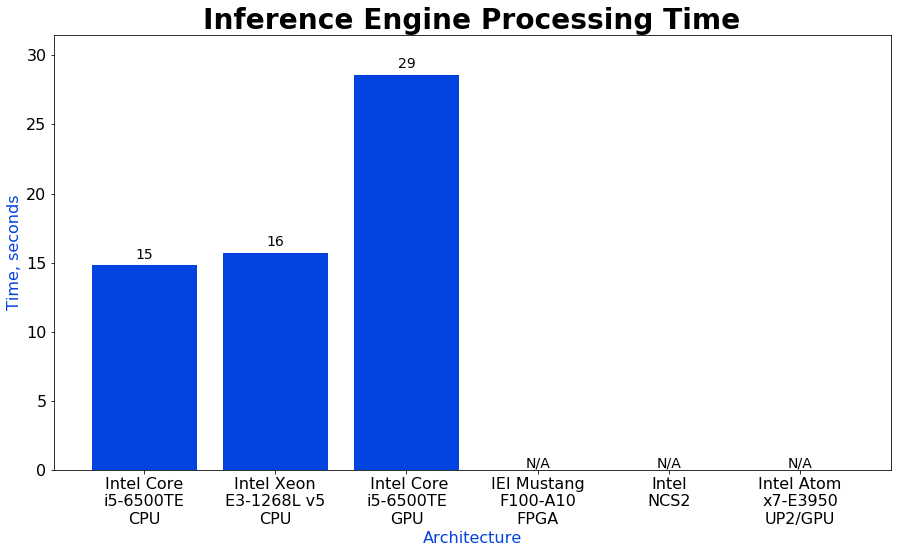

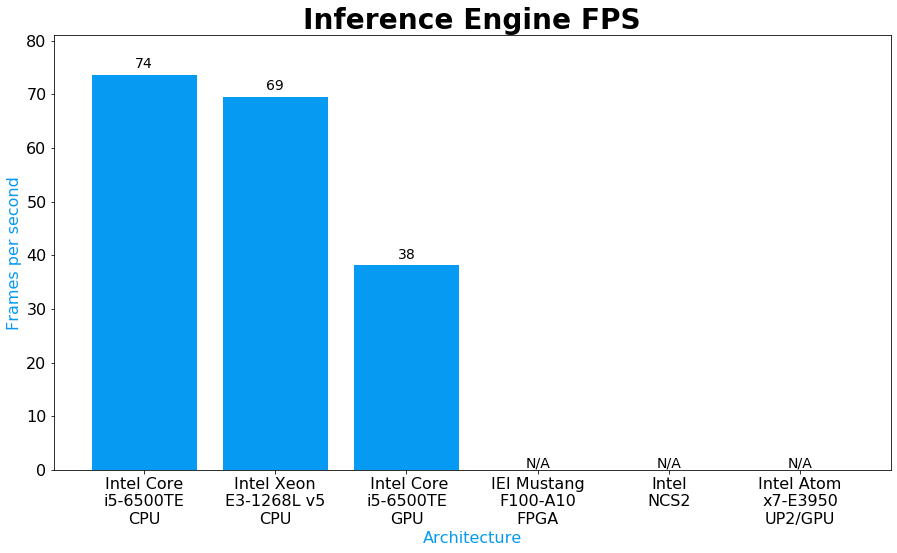

In [16]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('xeon', 'Intel Xeon\nE3-1268L v5\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),
             ('fpga', 'IEI Mustang\nF100-A10\nFPGA'),
             ('ncs2', 'Intel\nNCS2'),
             ('up2', 'Intel Atom\nx7-E3950\nUP2/GPU')]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/'+arch+'/stats'+'.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )